In [39]:
# Import data analysis libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Import machine learning libraries, modules
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

In [40]:
# Load training data from Kaggle
train_full = pd.read_csv('/kaggle/input/titanic/train.csv', index_col=0)

# Load test data from Kaggle
test_full = pd.read_csv('/kaggle/input/titanic/test.csv', index_col=0)

In [41]:
# Inspect data
train_full.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
# Inspect data
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [43]:
# Show count of unique value for each column
train_full.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [44]:
# Show unique values in 'Cabin' column
train_full.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [45]:
# Make new column 'CabinType' with the 1st character of 'Cabin'
train_full['CabinType'] = train_full['Cabin'].str[0]
train_full.CabinType.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [46]:
# Target feature
y = train_full.Survived

# Predictor features
X = train_full.drop('Survived', axis=1)

# Split train data and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [47]:
# Categorical columns
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'CabinType']

# Numerical columns
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']

In [48]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle numerical and categorical data transformer as preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [49]:
# Define test model
test_model = XGBClassifier(random_state=0, n_jobs=-1)

# Bundle preprocessor and test model in a pipeline
test_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', test_model)])

# Parameters for grid search
params = {
    "model__learning_rate" : [i/100 for i in range(6,10)],
    "model__max_depth": [8,9,10,11],
    "model__n_estimators" : [37,38,39,40,41]
}

# Define GridSearchCV with test pipeline and params
grid_search = GridSearchCV(test_pipeline, params, scoring='accuracy', n_jobs=-1, cv=5, verbose=0)

In [50]:
# Fit grid search
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'CabinT...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=0, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.06, 0.07, 0.08, 0.09],
                         'model__max_depth': [8, 9, 10, 11],
                         'model__n_estimators': [37, 38, 39, 40, 41]},
             scoring='accuracy')

In [51]:
# Print best parameters
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best params: {'model__learning_rate': 0.07, 'model__max_depth': 9, 'model__n_estimators': 38}
Best score: 0.8440148138848785


In [52]:
# Define model with optimal parameters
model = XGBClassifier(random_state=0, 
 n_estimators= 38,
 max_depth= 9,
 learning_rate= 0.07,
 n_jobs=-1)

# Bundle preprocessing and model in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'CabinType'])])),
                ('model',
                 XGBClassi...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.07,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=38, n_jobs=-1,
                               num_parallel_tree=None, random_state=0, ...))])

In [53]:
# Predict train data
pred_train = pipeline.predict(X_train)
print('Train accuracy:', accuracy_score(y_train, pred_train))

# Predict validation data
pred_valid = pipeline.predict(X_valid)
print('Valid accuracy:', accuracy_score(y_valid, pred_valid))

Train accuracy: 0.9143258426966292
Valid accuracy: 0.8603351955307262


<Axes: >

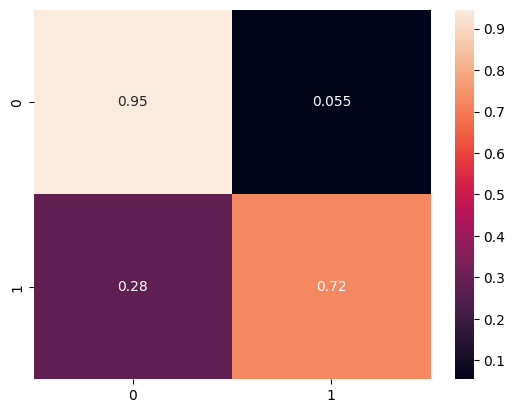

In [54]:
# Confusion matrix on validation data
sns.heatmap(confusion_matrix(y_valid, pred_valid, normalize='true'), annot=True)

In [55]:
# Cross validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Average accuracy:", scores.mean())
scores

Average accuracy: 0.8440148138848785


array([0.82681564, 0.8258427 , 0.89325843, 0.80337079, 0.87078652])

In [56]:
# Predict test data
pipeline.fit(X, y)
test_full['CabinType'] = test_full['Cabin'].str[0]
preds = pipeline.predict(test_full)

# Make submission file for Kaggle
output = pd.DataFrame({'PassengerId': test_full.index, 'Survived': preds})
output.to_csv('submission.csv', index=False)